# 最小二乘（Generalized Least Squares）

## 1. 最小二乘的基本

最小二乘法（generalized least squares）是一种数学优化技术，它通过最小化误差的平方和找到一组数据的最佳函数匹配。 最小二乘法通常用于曲线拟合、求解模型。很多其他的优化问题也可通过最小化能量或最大化熵用最小二乘形式表达。最小二乘原理的一般形式为：
$$
L = \sum (V_{obv} - V_{target}(\theta))^2
$$
其中$V_{obv}$是我们观测的多组样本值，$V_{target}$是我们假设拟合函数的输出值，$\theta$为构造模型的参数。$L$是目标函数，如果通过调整模型参数$\theta$，使得$L$下降到最小则表明，拟合函数与观测最为接近，也就是找到了最优的模型。


### 1.1 示例

假设我们有下面的一些观测数据，我们希望找到他们内在的规律。

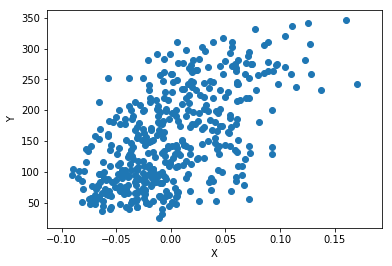

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn import datasets

# load data
d = datasets.load_diabetes()

X = d.data[:, 2]
Y = d.target

# draw original data
plt.scatter(X, Y)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


### 1.2 数学原理
有$N$个观测数据为：
$$
\mathbf{X} = \{x_1, x_2, ..., x_N \} \\
\mathbf{Y} = \{y_1, y_2, ..., y_N \}
$$
其中$\mathbf{X}$为自变量，$\mathbf{Y}$为因变量。

我们希望找到一个模型能够解释这些数据，假设我们使用最简单的线性模型来拟合数据：
$$
y = ax + b
$$
那么问题就变成求解参数$a$, $b$能够使得模型输出尽可能和观测数据有比较小的误差。

如何构建函数来评估模型输出与观测数据之间的误差是一个关键问题，这里我们使用观测数据与模型输出的平方和来作为评估函数（也被称为损失函数Loss function):
$$
L = \sum_{i=1}^{N} (y_i - a x_i - b)^2 \\
L = \sum_{i=1}^{N} \{y_i - (a x_i + b)\}^2
$$

使误差函数最小，那么我们就可以求出模型的参数:
$$
\frac{\partial L}{\partial a} = -2 \sum_{i=1}^{N} (y_i - a x_i - b) x_i \\
\frac{\partial L}{\partial b} = -2 \sum_{i=1}^{N} (y_i - a x_i - b)
$$
既当偏微分为0时，误差函数为最小，因此我们可以得到:
$$
-2 \sum_{i=1}^{N} (y_i - a x_i - b) x_i = 0 \\
-2 \sum_{i=1}^{N} (y_i - a x_i - b) = 0 \\
$$

将上式调整一下顺序可以得到：
$$
a \sum x_i^2 + b \sum x_i = \sum y_i x_i \\
a \sum x_i + b N = \sum y_i
$$
通过求解二元一次方程组，我们即可求出模型的最优参数。

### 1.3 求解程序

a = 949.435260, b = 152.133484


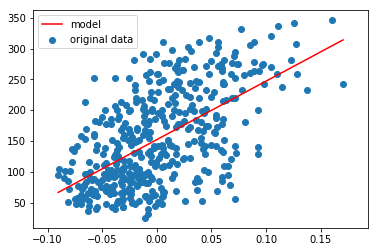

In [6]:
N = X.shape[0]

S_X2 = np.sum(X*X)
S_X  = np.sum(X)
S_XY = np.sum(X*Y)
S_Y  = np.sum(Y)

A1 = np.array([[S_X2, S_X], 
               [S_X, N]])
B1 = np.array([S_XY, S_Y])
# numpy.linalg模块包含线性代数的函数。使用这个模块，可以计算逆矩阵、求特征值、解线性方程组以及求解行列式等。
coeff = np.linalg.inv(A1).dot(B1)

print('a = %f, b = %f' % (coeff[0], coeff[1]))

x_min = np.min(X)
x_max = np.max(X)
y_min = coeff[0] * x_min + coeff[1]
y_max = coeff[0] * x_max + coeff[1]

plt.scatter(X, Y, label='original data')
plt.plot([x_min, x_max], [y_min, y_max], 'r', label='model')
plt.legend()
plt.show()

## 2. 如何使用迭代的方法求出模型参数

当数据比较多的时候，或者模型比较复杂，无法直接使用解析的方式求出模型参数。因此更为常用的方式是，通过迭代的方式逐步逼近模型的参数。

### 2.1 梯度下降法
在机器学习算法中，对于很多监督学习模型，需要对原始的模型构建损失函数，接下来便是通过优化算法对损失函数进行优化，以便寻找到最优的参数。在求解机器学习参数的优化算法中，使用较多的是基于梯度下降的优化算法(Gradient Descent, GD)。

梯度下降法有很多优点，其中最主要的优点是，在梯度下降法的求解过程中只需求解损失函数的一阶导数，计算的代价比较小，这使得梯度下降法能在很多大规模数据集上得到应用。梯度下降法的含义是通过当前点的梯度方向寻找到新的迭代点。

梯度下降法的基本思想可以类比为一个下山的过程。假设这样一个场景：一个人被困在山上，需要从山上下来(i.e. 找到山的最低点，也就是山谷)。但此时山上的浓雾很大，导致可视度很低。因此，下山的路径就无法确定，他必须利用自己周围的信息去找到下山的路径。这个时候，他就可以利用梯度下降算法来帮助自己下山。具体来说就是，以他当前的所处的位置为基准，寻找这个位置最陡峭的地方，然后朝着山的高度下降的地方走，同理，如果我们的目标是上山，也就是爬到山顶，那么此时应该是朝着最陡峭的方向往上走。然后每走一段距离，都反复采用同一个方法，最后就能成功的抵达山谷。


我们同时可以假设这座山最陡峭的地方是无法通过肉眼立马观察出来的，而是需要一个复杂的工具来测量，同时，这个人此时正好拥有测量出最陡峭方向的能力。所以，此人每走一段距离，都需要一段时间来测量所在位置最陡峭的方向，这是比较耗时的。那么为了在太阳下山之前到达山底，就要尽可能的减少测量方向的次数。这是一个两难的选择，如果测量的频繁，可以保证下山的方向是绝对正确的，但又非常耗时，如果测量的过少，又有偏离轨道的风险。所以需要找到一个合适的测量方向的频率，来确保下山的方向不错误，同时又不至于耗时太多！


![gradient_descent](images/gradient_descent.png)

如上图所示，得到了局部最优解。x,y表示的是$\theta_0$和$\theta_1$，z方向表示的是花费函数，很明显出发点不同，最后到达的收敛点可能不一样。当然如果是碗状的，那么收敛点就应该是一样的。

对于某一个损失函数
$$
L = \sum_{i=1}^{N} (y_i - a x_i - b)^2
$$

我们更新的策略是：
$$
\theta^1 = \theta^0 - \alpha \triangledown L(\theta)
$$
其中$\theta$代表了模型中的参数，例如$a$, $b$

此公式的意义是：$L$是关于$\theta$的一个函数，我们当前所处的位置为$\theta_0$点，要从这个点走到L的最小值点，也就是山底。首先我们先确定前进的方向，也就是梯度的反向，然后走一段距离的步长，也就是$\alpha$，走完这个段步长，就到达了$\theta_1$这个点！

下面就这个公式的几个常见的疑问：

* **$\alpha$是什么含义？**
$\alpha$在梯度下降算法中被称作为学习率或者步长，意味着我们可以通过$\alpha$来控制每一步走的距离，以保证不要步子跨的太大，错过了最低点。同时也要保证不要走的太慢，导致太阳下山了，还没有走到山下。所以$\alpha$的选择在梯度下降法中往往是很重要的。
![gd_stepsize](images/gd_stepsize.png)

* **为什么要梯度要乘以一个负号？**
梯度前加一个负号，就意味着朝着梯度相反的方向前进！梯度的方向实际就是函数在此点上升最快的方向，而我们需要朝着下降最快的方向走，自然就是负的梯度的方向，所以此处需要加上负号。



### 2.2 示例代码

epoch    0: loss = 4303817.496892, a = 2.826518, b = 90.332322
epoch    1: loss = 2886806.756007, a = 4.689320, b = 127.204624
epoch    2: loss = 2650260.562182, a = 6.564882, b = 142.423411
epoch    3: loss = 2610244.478756, a = 8.443497, b = 148.704446
epoch    4: loss = 2601826.873313, a = 10.321163, b = 151.296317
epoch    5: loss = 2598022.583256, a = 12.196235, b = 152.365440
epoch    6: loss = 2594693.583475, a = 14.068035, b = 152.806033
epoch    7: loss = 2591324.277053, a = 15.936290, b = 152.987193
epoch    8: loss = 2587904.879022, a = 17.800890, b = 153.061271
epoch    9: loss = 2584465.875668, a = 19.661796, b = 153.091151
epoch   10: loss = 2581025.689621, a = 21.518994, b = 153.102788
epoch   11: loss = 2577592.886376, a = 23.372484, b = 153.106897
epoch   12: loss = 2574171.135769, a = 25.222270, b = 153.107901
epoch   13: loss = 2570761.947715, a = 27.068358, b = 153.107623
epoch   14: loss = 2567365.917653, a = 28.910755, b = 153.106819
epoch   15: loss = 2563983.260

epoch  930: loss = 1741587.017634, a = 801.437656, b = 152.613670
epoch  931: loss = 1741500.026924, a = 801.731571, b = 152.613483
epoch  932: loss = 1741413.382452, a = 802.024898, b = 152.613295
epoch  933: loss = 1741327.082837, a = 802.317639, b = 152.613108
epoch  934: loss = 1741241.126703, a = 802.609794, b = 152.612922
epoch  935: loss = 1741155.512682, a = 802.901365, b = 152.612736
epoch  936: loss = 1741070.239409, a = 803.192353, b = 152.612550
epoch  937: loss = 1740985.305526, a = 803.482759, b = 152.612364
epoch  938: loss = 1740900.709678, a = 803.772585, b = 152.612179
epoch  939: loss = 1740816.450518, a = 804.061831, b = 152.611994
epoch  940: loss = 1740732.526703, a = 804.350498, b = 152.611810
epoch  941: loss = 1740648.936897, a = 804.638588, b = 152.611626
epoch  942: loss = 1740565.679766, a = 804.926103, b = 152.611442
epoch  943: loss = 1740482.753986, a = 805.213042, b = 152.611259
epoch  944: loss = 1740400.158233, a = 805.499407, b = 152.611076
epoch  945

epoch 1641: loss = 1720982.887695, a = 913.004991, b = 152.542413
epoch 1642: loss = 1720977.716578, a = 913.075808, b = 152.542368
epoch 1643: loss = 1720972.565804, a = 913.146484, b = 152.542322
epoch 1644: loss = 1720967.435291, a = 913.217018, b = 152.542277
epoch 1645: loss = 1720962.324960, a = 913.287412, b = 152.542232
epoch 1646: loss = 1720957.234731, a = 913.357664, b = 152.542188
epoch 1647: loss = 1720952.164523, a = 913.427776, b = 152.542143
epoch 1648: loss = 1720947.114257, a = 913.497748, b = 152.542098
epoch 1649: loss = 1720942.083855, a = 913.567580, b = 152.542053
epoch 1650: loss = 1720937.073238, a = 913.637272, b = 152.542009
epoch 1651: loss = 1720932.082327, a = 913.706825, b = 152.541965
epoch 1652: loss = 1720927.111044, a = 913.776239, b = 152.541920
epoch 1653: loss = 1720922.159311, a = 913.845514, b = 152.541876
epoch 1654: loss = 1720917.227051, a = 913.914650, b = 152.541832
epoch 1655: loss = 1720912.314187, a = 913.983648, b = 152.541788
epoch 1656

epoch 1929: loss = 1720089.587638, a = 928.521067, b = 152.532503
epoch 1930: loss = 1720087.915897, a = 928.560858, b = 152.532477
epoch 1931: loss = 1720086.250656, a = 928.600568, b = 152.532452
epoch 1932: loss = 1720084.591889, a = 928.640200, b = 152.532427
epoch 1933: loss = 1720082.939573, a = 928.679752, b = 152.532401
epoch 1934: loss = 1720081.293680, a = 928.719224, b = 152.532376
epoch 1935: loss = 1720079.654186, a = 928.758618, b = 152.532351
epoch 1936: loss = 1720078.021066, a = 928.797934, b = 152.532326
epoch 1937: loss = 1720076.394293, a = 928.837170, b = 152.532301
epoch 1938: loss = 1720074.773845, a = 928.876328, b = 152.532276
epoch 1939: loss = 1720073.159694, a = 928.915408, b = 152.532251
epoch 1940: loss = 1720071.551818, a = 928.954410, b = 152.532226
epoch 1941: loss = 1720069.950190, a = 928.993333, b = 152.532201
epoch 1942: loss = 1720068.354786, a = 929.032179, b = 152.532176
epoch 1943: loss = 1720066.765582, a = 929.070948, b = 152.532152
epoch 1944

epoch 2429: loss = 1719718.764672, a = 941.105371, b = 152.524465
epoch 2430: loss = 1719718.517995, a = 941.119997, b = 152.524456
epoch 2431: loss = 1719718.272238, a = 941.134594, b = 152.524447
epoch 2432: loss = 1719718.027398, a = 941.149161, b = 152.524437
epoch 2433: loss = 1719717.783470, a = 941.163699, b = 152.524428
epoch 2434: loss = 1719717.540451, a = 941.178208, b = 152.524419
epoch 2435: loss = 1719717.298338, a = 941.192688, b = 152.524409
epoch 2436: loss = 1719717.057128, a = 941.207140, b = 152.524400
epoch 2437: loss = 1719716.816816, a = 941.221562, b = 152.524391
epoch 2438: loss = 1719716.577400, a = 941.235955, b = 152.524382
epoch 2439: loss = 1719716.338876, a = 941.250320, b = 152.524373
epoch 2440: loss = 1719716.101240, a = 941.264656, b = 152.524363
epoch 2441: loss = 1719715.864489, a = 941.278963, b = 152.524354
epoch 2442: loss = 1719715.628620, a = 941.293242, b = 152.524345
epoch 2443: loss = 1719715.393629, a = 941.307492, b = 152.524336
epoch 2444

epoch 2871: loss = 1719664.715819, a = 945.400050, b = 152.521722
epoch 2872: loss = 1719664.665804, a = 945.406087, b = 152.521718
epoch 2873: loss = 1719664.615962, a = 945.412113, b = 152.521714
epoch 2874: loss = 1719664.566291, a = 945.418127, b = 152.521711
epoch 2875: loss = 1719664.516793, a = 945.424129, b = 152.521707
epoch 2876: loss = 1719664.467465, a = 945.430118, b = 152.521703
epoch 2877: loss = 1719664.418307, a = 945.436096, b = 152.521699
epoch 2878: loss = 1719664.369319, a = 945.442062, b = 152.521695
epoch 2879: loss = 1719664.320500, a = 945.448016, b = 152.521692
epoch 2880: loss = 1719664.271849, a = 945.453958, b = 152.521688
epoch 2881: loss = 1719664.223365, a = 945.459888, b = 152.521684
epoch 2882: loss = 1719664.175049, a = 945.465806, b = 152.521680
epoch 2883: loss = 1719664.126900, a = 945.471712, b = 152.521676
epoch 2884: loss = 1719664.078916, a = 945.477607, b = 152.521673
epoch 2885: loss = 1719664.031097, a = 945.483489, b = 152.521669
epoch 2886

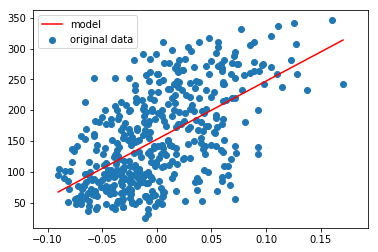

In [7]:
n_epoch = 3000          # epoch size
a, b = 1, 1             # initial parameters
epsilon = 0.001         # learning rate

for i in range(n_epoch):
    for j in range(N):
        a = a + epsilon*2*(Y[j] - a*X[j] - b)*X[j]
        b = b + epsilon*2*(Y[j] - a*X[j] - b)

    L = 0
    for j in range(N):
        L = L + (Y[j]-a*X[j]-b)**2
    print("epoch %4d: loss = %f, a = %f, b = %f" % (i, L, a, b))
    
x_min = np.min(X)
x_max = np.max(X)
y_min = a * x_min + b
y_max = a * x_max + b

plt.scatter(X, Y, label='original data')
plt.plot([x_min, x_max], [y_min, y_max], 'r', label='model')
plt.legend()
plt.show()

## 3. 如何可视化迭代过程

<IPython.core.display.Javascript object>


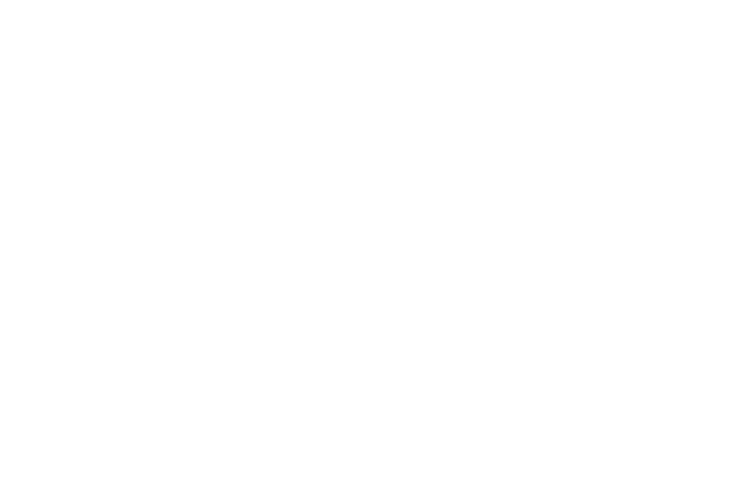

<IPython.core.display.Javascript object>


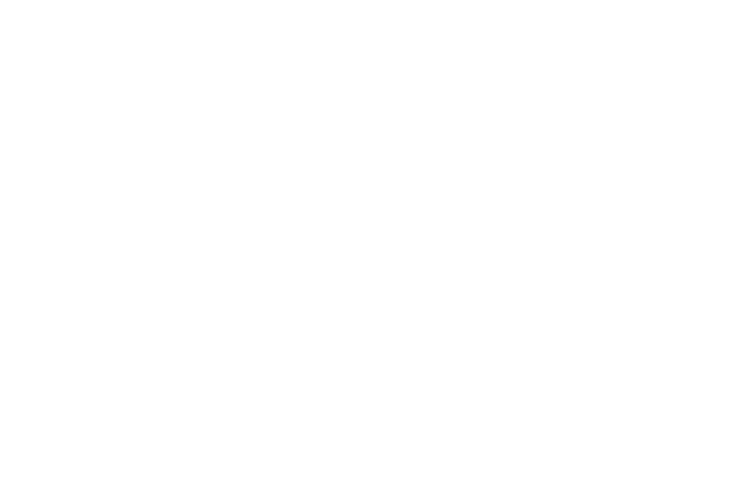

Traceback (most recent call last):
  File "/home/bushuhui/.virtualenv/dl/lib/python3.5/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/bushuhui/.virtualenv/dl/lib/python3.5/site-packages/matplotlib/animation.py", line 1462, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [10]:
%matplotlib nbagg

import matplotlib.pyplot as plt
import matplotlib.animation as animation

n_epoch = 3000          # epoch size
a, b = 1, 1             # initial parameters
epsilon = 0.001         # learning rate

fig = plt.figure()
imgs = []

for i in range(n_epoch):
    for j in range(N):
        a = a + epsilon*2*(Y[j] - a*X[j] - b)*X[j]
        b = b + epsilon*2*(Y[j] - a*X[j] - b)

    L = 0
    for j in range(N):
        L = L + (Y[j]-a*X[j]-b)**2
    #print("epoch %4d: loss = %f, a = %f, b = %f" % (i, L, a, b))
    
    if i % 50 == 0:
        x_min = np.min(X)
        x_max = np.max(X)
        y_min = a * x_min + b
        y_max = a * x_max + b

        img = plt.scatter(X, Y, label='original data')
        img = plt.plot([x_min, x_max], [y_min, y_max], 'r', label='model')
        imgs.append(img)
        
ani = animation.ArtistAnimation(fig, imgs)
plt.show()

## 4. 如何使用批次更新的方法？

如果有一些数据包含比较大的错误（异常数据），因此每次更新仅仅使用一个数据会导致不精确，同时每次仅仅使用一个数据来计算更新也导致计算效率比较低。


* [梯度下降方法的几种形式](https://blog.csdn.net/u010402786/article/details/51188876)

## 5. 如何拟合多项式函数？

需要设计一个弹道导弹防御系统，通过观测导弹的飞行路径，预测未来导弹的飞行轨迹，从而完成摧毁的任务。按照物理学，可以得知模型为:
$$
y = at^2 + bt + c
$$
我们需要求解三个模型参数$a, b, c$。

损失函数的定义为：
$$
L = \sum_{i=1}^N (y_i - at^2 - bt - c)^2
$$


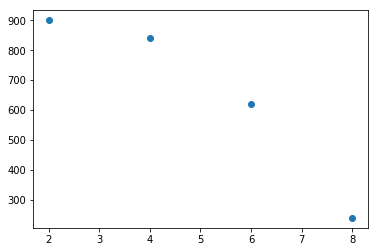

In [11]:
%matplotlib inline

t = np.array([2, 4, 6, 8])
#t = np.linspace(0, 10)

pa = -20
pb = 90
pc = 800

y = pa*t**2 + pb*t + pc


plt.scatter(t, y)
plt.show()

### 5.1 如何得到更新项?

$$
L = \sum_{i=1}^N (y_i - at^2 - bt - c)^2
$$

\begin{eqnarray}
\frac{\partial L}{\partial a} & = & - 2\sum_{i=1}^N (y_i - at^2 - bt -c) t^2 \\
\frac{\partial L}{\partial b} & = & - 2\sum_{i=1}^N (y_i - at^2 - bt -c) t \\
\frac{\partial L}{\partial c} & = & - 2\sum_{i=1}^N (y_i - at^2 - bt -c)
\end{eqnarray}

## 6. 如何使用sklearn求解线性问题？


a = 949.435260, b = 152.133484


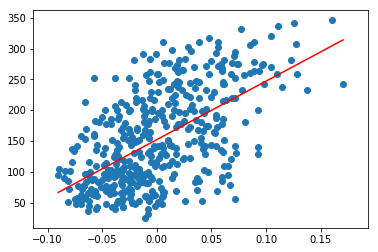

In [12]:
from sklearn import linear_model

# load data
d = datasets.load_diabetes()

X = d.data[:, np.newaxis, 2]
Y = d.target

# create regression model
regr = linear_model.LinearRegression()
regr.fit(X, Y)

a, b = regr.coef_, regr.intercept_
print("a = %f, b = %f" % (a, b))

x_min = np.min(X)
x_max = np.max(X)
y_min = a * x_min + b
y_max = a * x_max + b

plt.scatter(X, Y)
plt.plot([x_min, x_max], [y_min, y_max], 'r')
plt.show()

## 7. 如何使用sklearn拟合多项式函数？

In [10]:
# Fitting polynomial functions

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

t = np.array([2, 4, 6, 8])

pa = -20
pb = 90
pc = 800

y = pa*t**2 + pb*t + pc

model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])
model = model.fit(t[:, np.newaxis], y)
model.named_steps['linear'].coef_


array([800.,  90., -20.])